In [291]:
import random as rd
import os
import math
import statistics
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from numpy.random import choice
from numpy.random import uniform
from numpy.random import normal
from numpy.random import randint
from numpy.random import permutation
from numpy import corrcoef
from numpy import flip
from numpy import around
from numpy import array as nparray
from numpy import arange as arange
from random import choices as rdchoices
from random import uniform as rduniform
import numba as nb
import time
import scipy.stats
from scipy.stats import multivariate_normal as mvn
from sklearn.utils import shuffle
import statistics
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
from collections import Counter
from progress.bar import Bar
from scipy.stats import skewnorm
#import pandas as pd
from itertools import chain
import cProfile, pstats
from tqdm import tqdm
import seaborn as sns

In [315]:
class female:
    
    def __init__(self, f):
        
        self.ID = f
        self.status, self.cycleDay = "nonCycling", False
        self.conceptionProbability, myConceptionProbabilityList = 0, []
        self.daysUntilCycling = randint(rangeOfNonCyclingDays+1)
        self.daysUntilConception = False
        self.myConceptionProbabilityList = []
        self.genes = uniform(0,1)
        self.reproductiveSuccess = 0
        self.cost = 0
        
    def switchToCycling(self):
            
        self.cycleDay = 0
        self.status = "cycling"
        self.daysUntilConception = round(normal(meanDaysToConception, sdDaysToConception))
        self.conceptionProbability = conceptionProbabilityList[0]
        
    def switchToDone(self):
        
        self.cycleDay = False
        self.status = "done"
        

In [848]:
class male:
    
    def __init__(self, m):
        
        self.ID = m
        self.genes = uniform(0,1)
        self.quality =  0.5 - ((m / nMales) * 0.5) + (m / nMales + uniform(0,0.00000001))
        self.dominance = self.genes
        self.cost = self.dominance * (1 - self.quality)
        self.reproductiveSuccess = 0
        

In [849]:
seasonality = 0.0
nMales = 5
nFemales = 5
nGroups = 1

model = population()
print([m.quality for m in model.groups[0].males])
print([round(m.dominance,3) for m in model.groups[0].males])
print("\n")

model.groups[0].go()

print([m.quality for m in model.groups[0].males])
print([round(m.dominance,3) for m in model.groups[0].males])
print([round(m.reproductiveSuccess,3) for m in model.groups[0].males])
print("\n")

model.groups[0].setupNextGen()
model.groups[0].reset()
model.groups[0].setGenotypes()

print([round(m,3) for m in model.groups[0].offspringGenes])

print([m.quality for m in model.groups[0].males])
print([round(m.genes,3) for m in model.groups[0].males])
print([round(m.dominance,3) for m in model.groups[0].males])
print("\n")

model.groups[0].go()

print([m.quality for m in model.groups[0].males])
print([round(m.dominance,3) for m in model.groups[0].males])
print([round(m.reproductiveSuccess,3) for m in model.groups[0].males])
print("\n")

[0.5000000043574401, 0.6000000005196584, 0.7000000010504981, 0.8000000013473394, 0.9000000093050035]
[0.652, 0.259, 0.7, 0.795, 0.443]


[0.8000000013473394, 0.7000000010504981, 0.5000000043574401, 0.9000000093050035, 0.6000000005196584]
[0.795, 0.7, 0.652, 0.443, 0.259]
[9.343, 1.067, 0.0, 0.0, 0]


[0.259, 0.679, 0.7, 0.7, 0.71, 0.7, 0.443, 0.795, 0.795, 0.187]
[0.4, 0.0, 0.6, 0.2, 0.8]
[0.795, 0.7, 0.795, 0.443, 0.187]
[1.0, 0.8, 0.6, 0.4, 0.2]


[0.4, 0.0, 0.6, 0.2, 0.8]
[1.0, 0.8, 0.6, 0.4, 0.2]
[3.204, 0.0, 0.0, 0.0, 0.0]




In [746]:
pl = model.groups[0].conceptionProbabilities
choice(model.groups[0].females, p = [i / sum(pl) for i in pl])

In [1021]:
class group:
    
    def __init__(self, g):

        self.ID = g
        self.females = [female(f) for f in range(nFemales)]
        self.males = [male(m) for m in range(nMales)]
        self.modelDays = 0
    
    def go(self):
        
        self.males = sorted(self.males, key=self.sortDominance, reverse = True)

        for r in range(10000):
            self.modelDays += 1
            if all([item.status =="done" for item in self.females]):
                break

            self.females = sorted(self.females, key=self.sortConceptionProbability, reverse = True)
            
            self.conceptionProbabilities = [f.conceptionProbability for f in self.females]
            
            self.makeMatingPairs() if any(self.conceptionProbabilities) else 0

            for f in [item for item in self.females if item.status == "cycling"]:
                f.daysUntilConception -= 1
                f.cycleDay = f.cycleDay + 1 if f.cycleDay < cycleLength - 1 else 0
                f.conceptionProbability = conceptionProbabilityList[f.cycleDay]
                f.myConceptionProbabilityList += [conceptionProbabilityList[f.cycleDay]]
                f.switchToDone() if f.daysUntilConception == 0 else 0

            for f in [item for item in self.females if item.status == "nonCycling"]:
                f.daysUntilCycling -= 1
                f.myConceptionProbabilityList += [0]
                f.switchToCycling() if f.daysUntilCycling <= 0 else 0

            for f in [item for item in self.females if item.status == "done"]:
                f.myConceptionProbabilityList += [0]
        
        l = [m.reproductiveSuccess for m in self.males]
        k = [m.cost for m in self.males]
        j = np.array([i / sum(l) - j for i,j in zip(l,k)])

        j[j<0] = 0

        j = [i / sum(j) for i in j]

        for m in range(nMales):
            self.males[m].reproductiveSuccess = j[m]
        
        if self.ID == 0:
            model.listOfRSCorrels += [corrcoef([m.dominance for m in self.males],[m.reproductiveSuccess for m in self.males])[1,0]]
        
    def sortQuality(self, m):
        return m.quality
    
    def sortDominance(self, m):
        return m.dominance
    
    def sortConceptionProbability(self, f):
        return f.conceptionProbability
    
    def makeMatingPairs(self):
        
        i = 0
        nPairs = len([item for item in self.females if item.conceptionProbability > 0])
        while i < nPairs:
            self.males[i].reproductiveSuccess += self.females[i].conceptionProbability * self.males[i].quality
            self.females[i].reproductiveSuccess += self.females[i].conceptionProbability * self.males[i].quality
            i += 1
        
    def setupNextGen(self):
        
        self.nextGenMotherGenes = []
        motherProbabilities = [f.reproductiveSuccess for f in self.females]
        # lack of ability to chose becomes a cost as dominanceQualityCorrelation  goes down

        self.nextGenFatherGenes = []
        fatherProbabilities = np.array([m.reproductiveSuccess - m.cost for m in self.males]) # does male quality matter?
        #fatherProbabilities[fatherProbabilities < 0] = 0
                
        parentsStartingPoint = model.generation * model.nAgents
        
        moms = [rdchoices(model.potentialMoms[parentsStartingPoint + i: parentsStartingPoint + i + 2],
                          weights=[motherProbabilities[p] for p in model.potentialMoms[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]],k = 1)[0] for i in np.arange(0, (model.nAgents * 2), 2)]
        self.dads = [rdchoices(model.potentialDads[parentsStartingPoint + i:parentsStartingPoint + i + 2],
                          weights=[fatherProbabilities[p] for p in model.potentialDads[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]], k = 1)[0] for i in np.arange(0, (model.nAgents * 2), 2)]
        
        self.nextGenMotherGenes = [self.females[m].genes for m in moms]
        self.nextGenFatherGenes = [self.males[d].genes for d in self.dads]
        
        self.p = [m.reproductiveSuccess for m in self.males]
        
        self.recombination()
        self.mutation() if model.mutations[model.generation - 1] > 0 else 0
        self.reset()
        
#     def recombination(self):
        
#         self.offspringGenes = []
#         recombinationPoints = choice(range(model.numberGenes), model.nAgents)
#         splitTypes = randint(0,2, model.nAgents)
#         i = 0
#         while i < model.nAgents:
#             recombinationPoint = recombinationPoints[i]
#             if splitTypes[i] == 1:
#                 self.offspringGenes.append([m for m in self.nextGenMotherGenes[i][:recombinationPoint]] + 
#                                            [f for f in self.nextGenFatherGenes[i][recombinationPoint:]])
#             else:
#                 self.offspringGenes.append([f for f in self.nextGenFatherGenes[i][:recombinationPoint]] + 
#                                            [m for m in self.nextGenMotherGenes[i][recombinationPoint:]])
#             i += 1
            
    def recombination(self):
        
        self.offspringGenes = []
        splitTypes = randint(0,2, model.nAgents)
        i = 0
        while i < model.nAgents:
            if splitTypes[i] == 1:
                self.offspringGenes.append(self.nextGenMotherGenes[i])
            else:
                self.offspringGenes.append(self.nextGenFatherGenes[i])
            i += 1
            
    def mutation(self):
        
        genesInGroup =  model.nAgents
        mutations = model.mutations[model.generation - 1]
                
        offspringsMutating = choice(range(model.nAgents), mutations, replace=False)

        #genesMutating = choice([0,1], mutations)
        pertubations = uniform(-0.02,0.02, mutations)
        
        newGenes = nparray([self.offspringGenes[offspringsMutating[m]] + pertubations[m] for m in range(mutations)])
        
        newGenes[newGenes < 0] = 0
        
        for m in range(mutations):
            self.offspringGenes[offspringsMutating[m]] = newGenes[m]
        
    def setGenotypes(self):
        
        for f in self.females:
            f.genes = self.offspringGenes[f.ID]  + uniform(0,0.000001)

        for m in range(nMales):
            #m.genes = [uniform(0,1)] + [self.offspringGenes[m.ID + nFemales][1]]
            self.males[m].genes = self.offspringGenes[m + nFemales] + uniform(0,0.00000001)
            self.males[m].quality = self.males[self.dads[m]].quality + uniform(0,0.00000001)
            
        self.males = sorted(self.males, key=self.sortQuality, reverse = True)
        
        for m in range(nMales):
            self.males[m].quality = 0.5 - ((m / nMales) * 0.5) + (m / nMales + uniform(0,0.00000001))
        
        genesList = [m.genes for m in self.males]
        self.males = choice(self.males, replace=False, size = nMales, p = [i/sum(genesList) for i in genesList])
        
        for m in range(nMales):
            self.males[m].dominance = (nMales - m) / nMales
            self.males[m].cost = self.males[m].dominance * (1 - self.males[m].quality)

    def reset(self):
        self.modelDays = 0
        self.males, self.females = [], []
        self.males = [male(m) for m in range(nMales)]
        self.females = [female(f) for f in range(nFemales)]

cycleLength = 28
ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post


In [1022]:
class population:
    
    def __init__(self):
        
        self.listOfQualityCorrels = []
        self.listOfRSCorrels = []
        self.generation = 0
        self.numberGenes = 2
        self.rangeFemales = range(nFemales)
        self.rangeMales = range(nMales)
        self.nAgents = nMales + nFemales
        self.totalAgents = nGroups * self.nAgents
        self.rangeGroups = range(nGroups)
        self.mutations = [round(uniform(0,self.nAgents * mutationRate * 2)) for i in range(nGenerations * nGroups)]
        self.potentialMoms = rdchoices(range(nFemales), k = 3 * self.nAgents * nGenerations * nGroups)
        self.potentialDads = rdchoices(range(nMales), k = 3 * self.nAgents * nGenerations * nGroups)
        self.groups = [group(g) for g in self.rangeGroups]
    
    def evolve(self):

        %matplotlib qt

        for gen in tqdm(range(nGenerations)):

            self.listOfQualityCorrels += [corrcoef([m.dominance for m in self.groups[0].males],[m.quality for m in self.groups[0].males])[1,0]]
            
            self.plotDominanceQuality() if uniform(0,1) > 0.8 else 0
               
            self.generation += 1

            for group in self.groups:
                group.go()
                
                domList = [m.dominance for m in self.groups[0].males] if self.generation == nGenerations else 0
                group.setupNextGen()
                group.reset()
                group.setGenotypes()
                
                self.migration() if dispersal else 0
                    
        %matplotlib inline
        plt.plot(domList, self.groups[0].p)
        
        
    def migration(self):
                
        migrations = round(uniform(self.totalAgents * migrationRate * 2))
        groupsLeavingFrom = choice([g for g in self.groups], migrations)
        agentsLeaving = choice(range(nMales), migrations)
        
        for m in range(migrations):
            
            groupLeavingFrom = groupsLeavingFrom[m]
            
            if rd.uniform(0,1) > maleDispersalBias:
                agentLeaving = groupLeavingFrom.males[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).males)
            else:
                agentLeaving = groupLeavingFrom.females[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).females)
            
            tempGenes, tempCost = agentLeaving.genes, agentLeaving.cost
            agentLeaving.genes, agentLeaving.cost = agentComing.genes, agentComing.cost
            agentComing.genes, agentComing.cost = tempGenes, tempCost

    def plotDominanceQuality(self):
        
        plt.clf()
        plt.plot([m.quality for m in self.groups[0].males], [m.dominance for m in self.groups[0].males], 'bo')
        plt.text(0.1, 1.1,
             str(round(corrcoef([m.dominance
                                  for m
                                  in self.groups[0].males],[m.quality
                                                            for m
                                                            in self.groups[0].males])[1,0],2)))
        plt.xlim([0,1.2])
        plt.ylim([0,1.2])
        plt.pause(0.00001)
        plt.show()
        














  0%|          | 0/2 [00:00<?, ?it/s]












 50%|█████     | 1/2 [00:00<00:00,  5.48it/s]












100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


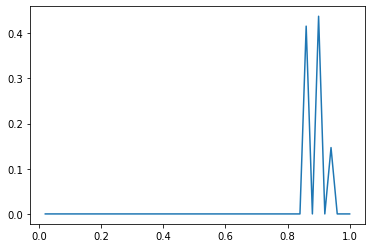

ERROR:tornado.application:Exception in callback functools.partial(<function Kernel.enter_eventloop.<locals>.advance_eventloop at 0x7fe447c8f0e0>)
Traceback (most recent call last):
  File "/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 314, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


In [1053]:
seasonality = 0.3

meanDaysToConception = 60
sdDaysToConception = 10

nGenerations = 2
mutationRate = 0.01

dispersal = True
migrationRate = 0.01
maleDispersalBias = 0.5

nFemales = 50
nMales = 50
nGroups = 5

#seasonality = s
rangeOfNonCyclingDays = 365 - (365 * seasonality)

model = population()
model.evolve()

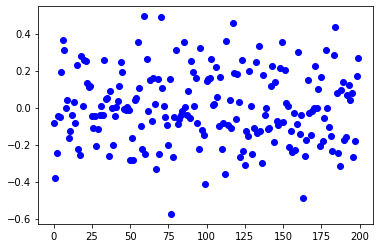

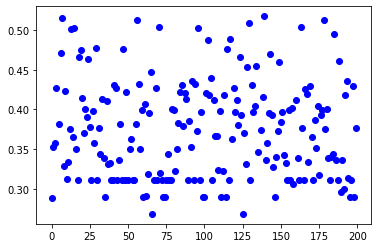

In [989]:
plt.plot(model.listOfQualityCorrels, 'bo')
plt.figure()
plt.plot(model.listOfRSCorrels, 'bo')

In [1027]:
model.groups[0].offspringGenes

[0.5958986477872505,
 0.19092734914819426,
 0.9309316428038624,
 0.23736827025725604,
 0.025008746093062473,
 0.9313235740962893,
 0.2827710372734498,
 0.42775263244667105,
 0.9309320322398549,
 0.5642630688649468,
 0.2827710372734498,
 0.16631641210661063,
 0.06686788886263977,
 0.025008746093062473,
 0.6745823341961158,
 0.5642630688649468,
 0.3188150058001825,
 0.07208253439857988,
 0.41117667962100496,
 0.3109771005099127,
 0.3109771005099127,
 0.06686788886263977,
 0.025008746093062473,
 0.3188150058001825,
 0.771345169685323,
 0.9309320322398549,
 0.6424567765854489,
 0.9309320322398549,
 0.06686788886263977,
 0.06686788886263977,
 0.3705558595033302,
 0.6424567765854489,
 0.42775263244667105,
 0.5958986477872505,
 0.3109771005099127,
 0.807823615750849,
 0.41117667962100496,
 0.19817858803553592,
 0.4017795653561609,
 0.025008746093062473,
 0.025008746093062473,
 0.13148875627256512,
 0.025008746093062473,
 0.5490780873880169,
 0.6745823341961158,
 0.4469289633917823,
 0.2533821

In [1034]:
[m.conceptionProbability for m in model.groups[0].females]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [1056]:
[m.genes for m in model.groups[0].males]

[0.8953759568470739,
 0.38716139039982217,
 0.8933599825499023,
 0.6999317997413911,
 0.9193274320918132,
 0.5532434118877068,
 0.7223800175102142,
 0.8953759561632894,
 0.7619165078038532,
 0.7788285864105806,
 0.9920472066285304,
 0.8779302760667259,
 0.93730967831572,
 0.5156153904463279,
 0.16974533904229547,
 0.9425670914758069,
 0.3233021007011429,
 0.13305150633058616,
 0.8827310713618292,
 0.38215337216561246,
 0.4625604981400941,
 0.7195909924578793,
 0.6811272074339705,
 0.6179265646999718,
 0.7488105199998554,
 0.29543728288468696,
 0.5532434155424244,
 0.03376157508834977,
 0.9920479146976208,
 0.16599924391307663,
 0.39973355176753245,
 0.5983676972261963,
 0.5860911447098599,
 0.14427524821957782,
 0.0062068853339314,
 0.29543728551230647,
 0.09300432483959635,
 0.187141475365507,
 0.29543728228306526,
 0.0028550421810170546,
 0.007883459718910088,
 0.002855701778678914,
 0.09300432362451873,
 0.0062063220175253364,
 0.0028550492525488587,
 0.006206317497579092,
 0.006206

In [1055]:
[m.dominance for m in model.groups[0].males]

[1.0,
 0.98,
 0.96,
 0.94,
 0.92,
 0.9,
 0.88,
 0.86,
 0.84,
 0.82,
 0.8,
 0.78,
 0.76,
 0.74,
 0.72,
 0.7,
 0.68,
 0.66,
 0.64,
 0.62,
 0.6,
 0.58,
 0.56,
 0.54,
 0.52,
 0.5,
 0.48,
 0.46,
 0.44,
 0.42,
 0.4,
 0.38,
 0.36,
 0.34,
 0.32,
 0.3,
 0.28,
 0.26,
 0.24,
 0.22,
 0.2,
 0.18,
 0.16,
 0.14,
 0.12,
 0.1,
 0.08,
 0.06,
 0.04,
 0.02]

In [768]:
seasonality = 1.0

meanDaysToConception = 60
sdDaysToConception = 10

nGenerations = 200
mutationRate = 0.01

dispersal = True
migrationRate = 0.01
maleDispersalBias = 0.5

nFemales = 10
nMales = 10
nGroups = 10

#seasonality = s
rangeOfNonCyclingDays = 365 - (365 * seasonality)
g = group(0)
g.evolve()

TypeError: __init__() missing 1 required positional argument: 'g'

In [975]:
nFemales = 30
nMales = 30
seasonality = 0.0

g = group(0)

g.go()

print([round(m.reproductiveSuccess,2) for m in g.males])
print([round(m.dominance,3) for m in g.males])
print([round(m.quality,2) for m in g.males])
print([round(m.cost,2) for m in g.males])


l = [m.reproductiveSuccess for m in g.males]
k = [m.cost for m in g.males]
j = np.array([i / sum(l) - j for i,j in zip(l,k)])

j[j<0] = 0

j = [i / sum(j) for i in j]

for m in range(nMales):
    g.males[m].reproductiveSuccess = j[m]

print([m.reproductiveSuccess for m in g.males])


[57.17, 36.4, 44.42, 21.92, 8.32, 4.75, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.991, 0.979, 0.977, 0.971, 0.967, 0.964, 0.956, 0.835, 0.761, 0.689, 0.663, 0.574, 0.556, 0.497, 0.471, 0.409, 0.391, 0.376, 0.296, 0.291, 0.285, 0.235, 0.228, 0.225, 0.204, 0.123, 0.078, 0.071, 0.014, 0.012]
[0.62, 0.57, 0.98, 0.8, 0.67, 0.9, 0.83, 0.78, 0.95, 0.6, 0.82, 0.75, 0.93, 0.58, 0.65, 0.63, 0.87, 0.92, 0.73, 0.7, 0.68, 0.55, 0.52, 0.77, 0.88, 0.97, 0.85, 0.53, 0.72, 0.5]
[0.38, 0.42, 0.02, 0.19, 0.32, 0.1, 0.16, 0.18, 0.04, 0.28, 0.12, 0.14, 0.04, 0.21, 0.16, 0.15, 0.05, 0.03, 0.08, 0.09, 0.09, 0.11, 0.11, 0.05, 0.02, 0.0, 0.01, 0.03, 0.0, 0.01]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [945]:
choice([1,2,3,4,5], p = j)

ValueError: 'a' and 'p' must have same size

/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


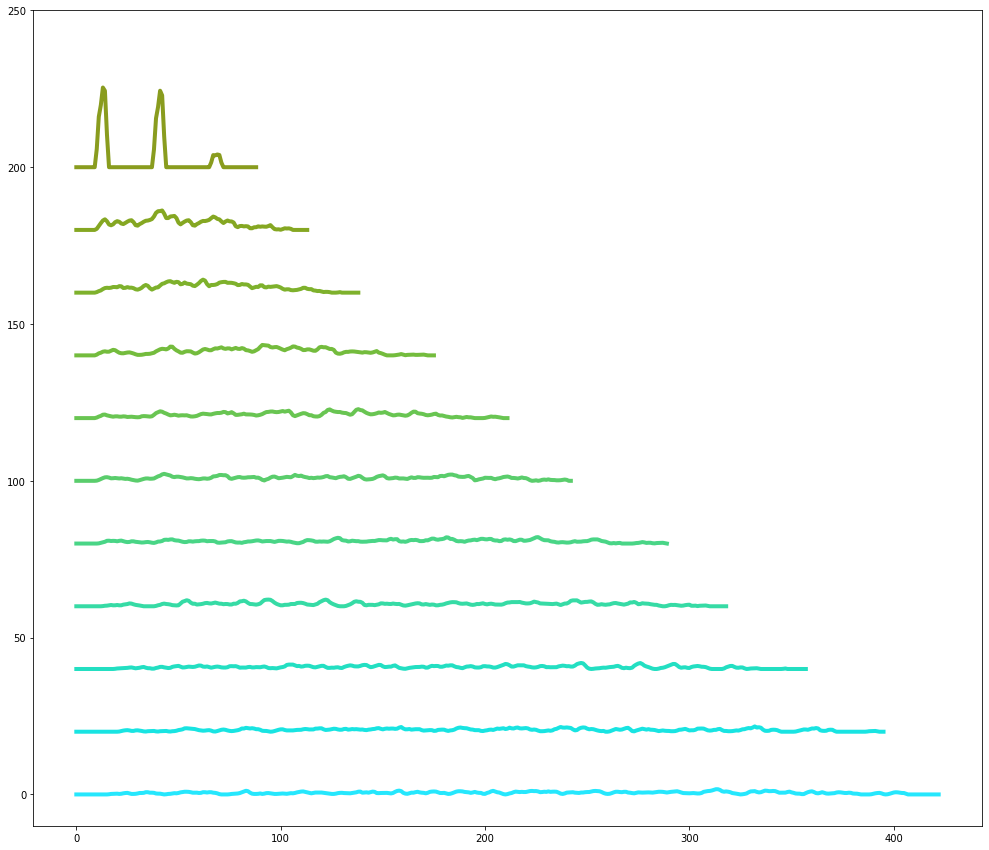

In [1014]:
nFemales = 100
nMales = 100
seasonality = 0.8

meanDaysToConception = 60
sdDaysToConception = 10

palette = np.flip(sns.color_palette("viridis",5550))
nGenerations = 1

plt.figure(figsize=(17, 15))

a = 0
#for n in [5,15,25,40,65,85,100,200,300,500]:
for s in arange(0.0, 1.1, 0.1):
    #nFemales = n
    #nMales = n
    seasonality = s
    rangeOfNonCyclingDays = 365 - (365 * seasonality)
    g = group(0)
    g.go()

    totalProb = [0] * g.modelDays
    for i in range(g.modelDays):
        totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in g.females]) + a*20

    allDaysTotal = plt.plot(range(g.modelDays), totalProb, color = palette[round(a*250)], linewidth=4)
    plt.ylim([-10,250])
    
    a += 1

In [781]:
[m.reproductiveSuccess for m in g.males]

[34.394969184297416,
 20.26477165432288,
 10.65881634863111,
 27.8876479837991,
 24.787055742869054,
 7.54260568737412,
 7.143530426901319,
 15.449815668188036,
 11.09813821011571,
 8.719309303329622,
 8.753031271599646,
 21.079960024919856,
 5.237937403077662,
 4.501299555031235,
 14.892800465600779,
 23.32051464622179,
 4.239957238355945,
 22.97505287166943,
 10.169571737289008,
 11.486789926271259,
 26.216041161248,
 1.0855360232648068,
 16.782323485972586,
 26.264667777941174,
 13.660514642725724,
 24.899244348149377,
 17.57633066225092,
 24.786557761984906,
 15.108893602516098,
 1.5477275005908329,
 1.6414427733441421,
 21.469366608357653,
 9.375541140452095,
 20.09203939578828,
 13.369181593441585,
 17.9540374015773,
 17.755435965689085,
 10.978558727442927,
 15.82795179351419,
 13.285503194087767,
 0.22410766889726869,
 6.935714451827934,
 8.826035246153051,
 1.7127086680272436,
 8.172899336423571,
 13.584635182596696,
 5.708334722066796,
 15.407078095301703,
 5.187097964004775,

In [381]:
[m.dominance for m in g.males]

[0.9172926048266851,
 0.9125330953227236,
 0.8671814652269741,
 0.6536187691375046,
 0.5014496071697704,
 0.4400310332955064,
 0.4316778539117011,
 0.40903726319739264,
 0.2059856225370461,
 0.12488048364511273]

In [717]:
def synchronyCharts(group):
    
    plt.figure(figsize=(20, nFemales / 2))
    allDays = plt.scatter([range(group.modelDays)] * nFemales, [[f.myConceptionProbabilityList[i] + f.ID
                                        for i in range(group.modelDays)]
                                       for f in group.females], s=8)

    totalProb = [0] * group.modelDays

    for i in range(group.modelDays):
        totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in group.females]) - 2

    allDaysTotal = plt.scatter([range(group.modelDays)], totalProb)
    
    groupConceptionProbabilities = []
    lenFertilePerDay = group.modelDays
    
    for d in range(group.modelDays):
        groupConceptionProbabilities += [sum([0 if f.myConceptionProbabilityList[d] == False else 1 for f in group.females])]

    fertilePerDay = [groupConceptionProbabilities.count(i) / group.modelDays for i in range(nFemales + 1)]

    for day in np.flip(range(len(fertilePerDay))):
        if fertilePerDay[day] ==  0:
            fertilePerDay.pop(day)
        else:
            break

    t = 0
    for i in range(len(fertilePerDay)):
        t += (groupConceptionProbabilities.count(i) / group.modelDays)
        fertilePerDay += [t]


    d = pd.DataFrame([[round(f*cycleLength,1) for f in fertilePerDay],
                      [f for f in range(round(len(fertilePerDay)/2))]*2,
                      ["day" for f in range(round(len(fertilePerDay)/2))] +
                      ["cumulative" for f in range(round(len(fertilePerDay)/2))]],
                     index=["numberFertile", "day", "category"]).T

    plt.figure(figsize=(18, 5))
    fertilePerDayPlot = sns.barplot("day", "numberFertile", data = d, hue = 'category')

    plt.bar_label(fertilePerDayPlot.containers[0], size = 13)
    plt.bar_label(fertilePerDayPlot.containers[1], size = 13)
    xlabel = plt.xlabel('Number of females in POP', size=25)
    ylabel = plt.ylabel('Average number of days per cycle', size=25)
    ylim = plt.ylim([0,110])

In [718]:
meanDaysToConception = 60
sdDaysToConception = 10

cycleLength = 28

ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post



133
74


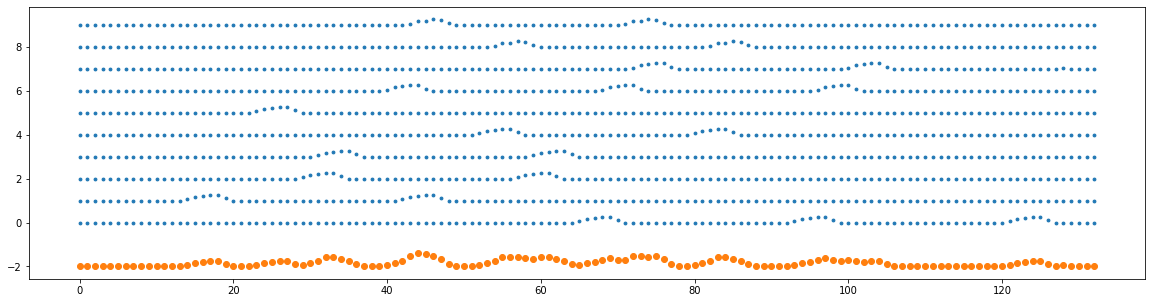

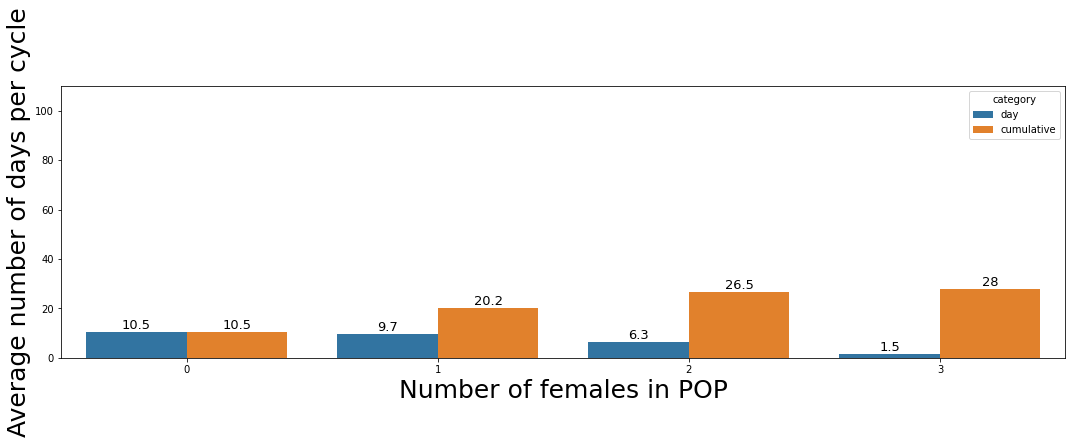

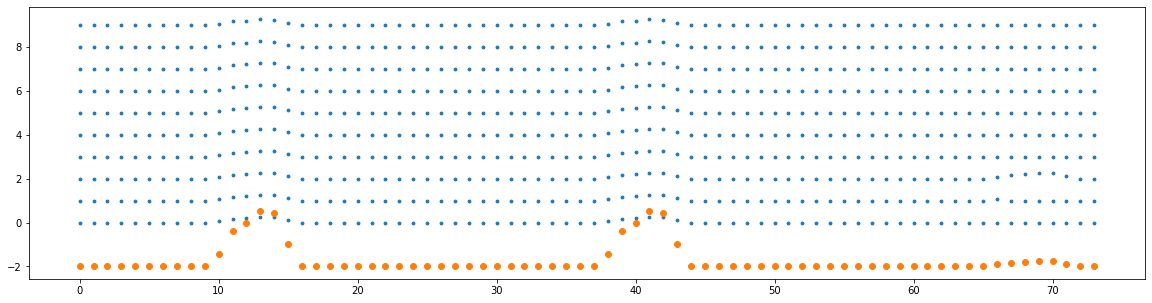

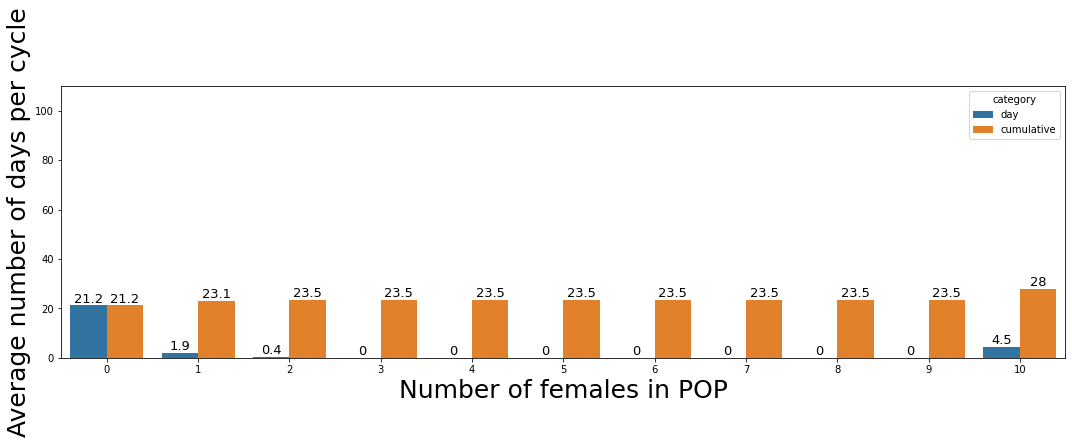

In [1002]:
nMales = 10
nFemales = 10

seasonality = 0.8
rangeOfNonCyclingDays = 365 - (365 * seasonality)

g = group(0)
g.go()

synchronyCharts(g)

print(g.modelDays)

nFemales = 10
nMales = 10

seasonality = 1.0
rangeOfNonCyclingDays = 365 - (365 * seasonality)

g = group(0)
g.go()

synchronyCharts(g)

print(g.modelDays)